# Defining trait space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import cmocean
import constants
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import pandas as pd
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Load traits database

A subset of the trait data from {cite:t}`Deutsch-Penn-etal-2020`, including only the marine organisms for which temerature-dependent hypoxia metabolic traits have been determined. 

The `open_traits_df` function is defined in the [metabolic](https://github.com/matt-long/aerobic-safety-margins/blob/main/notebooks/metabolic.py) module and  makes the trait data available via a [pandas](https://pandas.pydata.org/) `DataFrame`.

In [3]:
df = mi.open_traits_df(add_ATmax=True)
df

,Species,Phylum,alphaD_log10,Emet,Eo,Ao,Ac,Phi_crit,ATmax_active,ATmax_resting
0,Acanthephyra acutifrons,Crustacea,0.479565,0.040200,-0.027836,0.264715,0.131959,2.006040,34.537414,40.329376
1,Acanthephyra curtirostris,Crustacea,0.377714,0.043938,0.038027,0.252578,0.141861,1.780456,33.674001,38.427845
2,Acanthephyra purpurea,Crustacea,1.035748,0.840722,0.131972,0.230068,0.073638,3.124330,24.602842,35.679438
3,Acanthephyra smithi,Crustacea,1.082577,0.313173,-0.030067,0.286307,0.174423,1.641453,37.082006,40.961148
4,Acipenser brevirostrum,Chordata,NaN,NaN,0.362569,0.218524,0.048415,4.513525,15.523251,31.128123
...,...,...,...,...,...,...,...,...,...,...
56,Styela plicata,Tunicata,0.433791,0.346635,-0.190998,0.061336,0.043505,1.409863,NaN,29.776087
57,Systellaspis debilis,Crustacea,0.779626,0.418652,0.226970,0.219289,0.096003,2.284196,26.170657,33.458520
58,Tarletonbeania crenularis,Chordata,NaN,NaN,0.213307,0.203696,0.051780,3.933876,17.531769,33.144691
59,Tautogolabrus adspersus,Chordata,0.801974,0.327012,0.244520,0.170886,0.051204,3.337395,17.067168,31.182050


## Illustrating trait distributions

Recall the definition of the [Metabolic Index](./metabolic-index-defining.ipynb):

$$
  \Phi = A_o \frac{P_{\mathrm{O}_2}}
  {\mathrm{exp}\left[
  \frac{-E_o}{k_B}\left(
  \frac{1}{T} - \frac{1}{T_{ref}}
  \right)
  \right]
  }
$$


Parameters relevant to defining trait space:
- $E_o$: Temperature sensitivity of metabolic rates.
- $A_o$: Hypoxic tolerance for resting metabolism.
- $\Phi_{crit}$: lowest value of Metabolic Index at which *active* metabolism can be sustained.

Since active metabolism requires $\Phi >= \Phi_{crit}$, we can directly compute values of the Metabolic Index relevant for active metabolic rates, defining a new parameter:
- $A_c$: Hypoxic tolerance for active metabolism (i.e., $A_o / \Phi_{crit}$)


The hidden code below defines a function for plotting trait histograms.

In [4]:
def plot_trait_hist(df, trait):
    fig, ax = plt.subplots()

    pdf = mi.trait_pdf(df, trait, 30)
    beta = pdf.beta
    trait_median = pdf.median()

    trait_values = df[trait].values
    if trait in pdf.normal_traits:
        n, bins, h = ax.hist(trait_values, 30, density=True)
    else:
        log10_values = np.log10(trait_values)
        n, bins, h = ax.hist(
            trait_values, np.logspace(log10_values.min(), log10_values.max(), 30), density=True
        )

    ax.plot(pdf.coord, pdf.pdf)
    ax.set_title(f'{trait} distribution')
    ax.set_xlabel(f"{df[trait].attrs['long_name']} {df[trait].attrs['units']}")

    ax.axvline(trait_median, color='black', label=f'median ({trait_median:0.3f})')

    ax.legend()
    return trait_median, beta

The following plots illustrate trait distributions. 

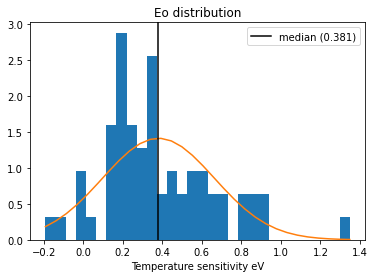

In [5]:
Eo_med, Eo_beta = plot_trait_hist(df, 'Eo')

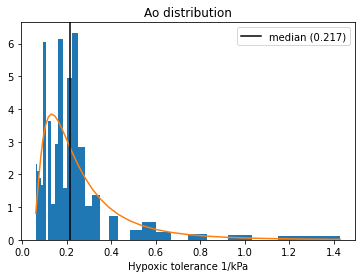

In [6]:
Ao_med, Ao_beta = plot_trait_hist(df, 'Ao')

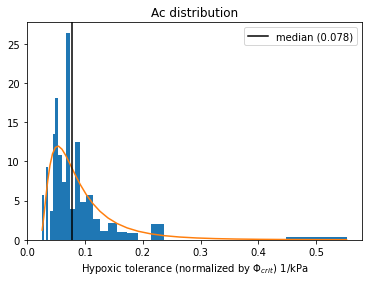

In [7]:
Ac_med, Ac_beta = plot_trait_hist(df, 'Ac')

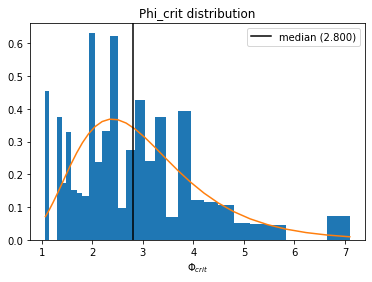

In [8]:
Phi_crit_med, Phi_crit_beta = plot_trait_hist(df, 'Phi_crit')

These individual traits can be combined into a joint probability distribution defining a "metabolic trait space." Here we illustrate an idealized version of this trait space, fitting a normal distribution to $E_o$ and a lognormal distribution to $A_c = A_o/\Phi_{crit}$.

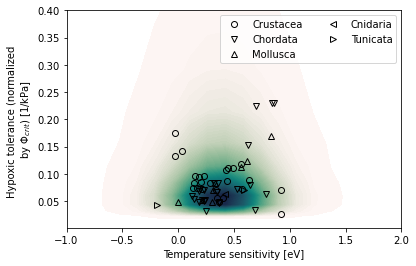

In [9]:
markerorder = ["o", "v", "^", "<", ">", "s", "p", "P"]

Phyla = list(df.Phylum.unique())

Eo_fit = mi.trait_pdf(df, 'Eo', 20, [-1, 2])
Ac_fit = mi.trait_pdf(df, 'Ac', 20, [0.001, 0.4])

# Eo_bins = np.linspace(-1.0, 2.0, 30)
# Ac_bins = np.logspace(-3, np.log10(df.Ac.max()), 50)

X, Y = np.meshgrid(Eo_fit.coord, Ac_fit.coord)
Z1, Z2 = np.meshgrid(Eo_fit.pdf, Ac_fit.pdf)

fig, ax = plt.subplots()  # figsize=(6, 6))

mx = np.max(Z1 * Z2)
cf = ax.contourf(
    X,
    Y,
    Z1 * Z2 / mx,
    cmap=cmocean.cm.tempo,
    levels=np.arange(0.001, 1.02, 0.01),
)

xlm = ax.get_xlim()
ylm = ax.get_ylim()
for i, phylum in enumerate(Phyla):
    ndx = df.Phylum == phylum
    ax.plot(
        df.Eo.loc[ndx],
        df.Ac.loc[ndx],
        linestyle='none',
        marker=markerorder[i],
        color='k',
        markerfacecolor='none',
        label=phylum,
    )

ax.set_xlabel(util.attrs_label(df.Eo.attrs))
ax.set_ylabel(util.attrs_label(df.Ac.attrs))

ax.set_xlim(xlm)
ax.set_ylim(ylm)

ax.legend(ncol=2)
plt.savefig(f'figures/misc/trait-space-idealized.png', dpi=300)

## Define the trait space for analysis

Trait space can be thought of something like an integration kernel, which enables computing the net capacity of the ocean to support aerobic metabolism, inclusive of the trait density distribution for ecothermic organisms. 

In the sequence of operations below, we build two versions of the idealized trait space distribution:
- a low resolution (in trait space) version enabling analysis with the Earth system model;
- a high resolution version for more refined assessments of habitat and trait variability.

### Define trait-coordinates 

Hypoxic tolerance is quantified by either $A_o$ (resting) or $A_c = {A_o}/{\Phi_{crit}}$. As illustrated above, both $A_o$ and $A_c$ are lognormally distributed. To harmonize these two coordinates of trait space, we first fit lognormal distributions to $A_c$ and $A_c$; then we use the CDF and "percentage point function" to determine a common "percentile" coordinate for both distributions.

See also:
[scipy.stats.lognormal documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)

First, fit $A_c$.

,Ac,PDF,CDF
0,0.0300,3.926803,0.012578
1,0.0370,8.427573,0.056621
2,0.0456,11.385733,0.143946
3,0.0562,11.869385,0.269404
4,0.0693,10.377166,0.416393
5,0.0854,7.939445,0.563752
6,0.1053,5.431292,0.695479
7,0.1299,3.365103,0.801594
8,0.1601,1.910592,0.878990
9,0.1974,0.995958,0.931125


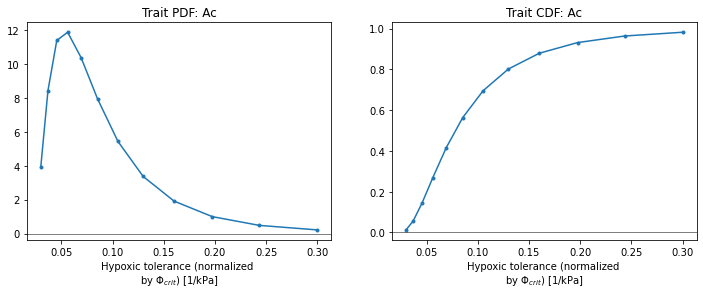

In [10]:
obj_Ac_pdf = mi.trait_pdf(df, 'Ac', 12, [0.03, 0.3])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(obj_Ac_pdf.coord, obj_Ac_pdf.pdf, '.-')
axs[0].set_title('Trait PDF: Ac')
axs[0].set_xlabel(util.attrs_label(df.Ac.attrs))
axs[0].axhline(0.0, linewidth=0.5, color='k')

axs[1].plot(obj_Ac_pdf.coord, obj_Ac_pdf.cdf, '.-')
axs[1].set_title('Trait CDF: Ac')
axs[1].set_xlabel(util.attrs_label(df.Ac.attrs))
axs[1].axhline(0.0, linewidth=0.5, color='k')

pd.DataFrame({'Ac': obj_Ac_pdf.coord, 'PDF': obj_Ac_pdf.pdf, 'CDF': obj_Ac_pdf.cdf})

Now fit $A_c$ and determine the equivalent percentiles as $A_c$ for the coordinate. Reinstantiate the `mi.trait_pdf` object with this coordinate.

,Ao,PDF,CDF
0,0.068106,1.361252,0.012578
1,0.088674,2.823929,0.056621
2,0.114712,3.713510,0.143946
3,0.147614,3.782377,0.269404
4,0.189177,3.238422,0.416393
5,0.241291,2.430414,0.563752
6,0.306919,1.632652,0.695479
7,0.389502,0.994097,0.801594
8,0.492625,0.555055,0.878990
9,0.622110,0.284666,0.931125


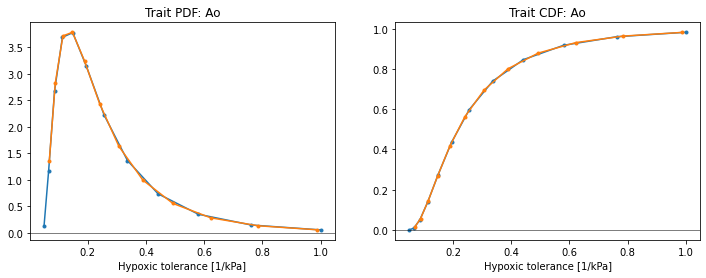

In [11]:
obj_Ao_pdf_i = mi.trait_pdf(df, 'Ao', 12, [0.05, 1.0])
A_percentile = obj_Ac_pdf.cdf
Ac_percentile_to_Ac_coord = obj_Ao_pdf_i.pdf_func.ppf(A_percentile, *obj_Ao_pdf_i.beta)

obj_Ao_pdf = mi.trait_pdf(df, 'Ao', coord_data=Ac_percentile_to_Ac_coord)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(obj_Ao_pdf_i.coord, obj_Ao_pdf_i.pdf, '.-', label='initial')
axs[0].plot(obj_Ao_pdf.coord, obj_Ao_pdf.pdf, '.-', label='final')

axs[0].set_title('Trait PDF: Ao')
axs[0].set_xlabel(util.attrs_label(df.Ao.attrs))
axs[0].axhline(0.0, linewidth=0.5, color='k')


axs[1].plot(obj_Ao_pdf_i.coord, obj_Ao_pdf_i.cdf, '.-', label='initial')
axs[1].plot(obj_Ao_pdf.coord, obj_Ao_pdf.cdf, '.-', label='final')
axs[1].set_title('Trait CDF: Ao')
axs[1].set_xlabel(util.attrs_label(df.Ao.attrs))
axs[1].axhline(0.0, linewidth=0.5, color='k')

pd.DataFrame({'Ao': obj_Ao_pdf.coord, 'PDF': obj_Ao_pdf.pdf, 'CDF': obj_Ao_pdf.cdf})

Now fit $E_o$, simple normal distribution.

,Eo,PDF,CDF
0,-0.500000,0.011103,0.000927
1,-0.305600,0.074421,0.007643
2,-0.111100,0.311325,0.041096
3,0.083300,0.811600,0.146622
4,0.277800,1.319801,0.358077
5,0.380678,1.409992,0.500000
6,0.472200,1.338123,0.626830
7,0.666700,0.845885,0.843967
8,0.861100,0.333549,0.955243
9,1.055600,0.081964,0.991470


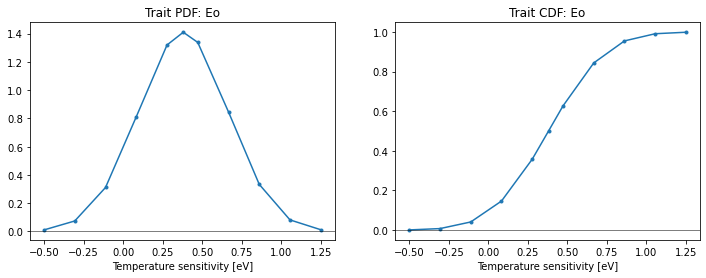

In [12]:
obj_Eo_pdf = mi.trait_pdf(df, "Eo", 10, [-0.5, 1.25])

# add median trait to percentiles
Eo_percentile = np.insert(obj_Eo_pdf.cdf, np.where(obj_Eo_pdf.cdf > 0.5)[0][0], 0.5)

# remake pdf with coord that includes median trait
obj_Eo_pdf = mi.trait_pdf(
    df, "Eo", coord_data=obj_Eo_pdf.pdf_func.ppf(Eo_percentile, *obj_Eo_pdf.beta)
)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(obj_Eo_pdf.coord, obj_Eo_pdf.pdf, ".-")
axs[0].set_title("Trait PDF: Eo")
axs[0].set_xlabel(util.attrs_label(df.Eo.attrs))
axs[0].axhline(0.0, linewidth=0.5, color="k")

axs[1].plot(obj_Eo_pdf.coord, obj_Eo_pdf.cdf, ".-")
axs[1].set_title("Trait CDF: Eo")
axs[1].set_xlabel(util.attrs_label(df.Eo.attrs))
axs[1].axhline(0.0, linewidth=0.5, color="k")

pd.DataFrame({"Eo": obj_Eo_pdf.coord, "PDF": obj_Eo_pdf.pdf, "CDF": obj_Eo_pdf.cdf})

### Generate a low-resolution trait space

In [13]:
def gen_trait_space(obj_Ac_pdf, obj_Ao_pdf, obj_Eo_pdf):

    assert len(obj_Ac_pdf.coord) == len(obj_Ao_pdf.coord)

    dso = xr.Dataset()
    dso['Ao_cdf'] = xr.DataArray(obj_Ao_pdf.cdf, dims=('Ao'))
    dso['Ac_cdf'] = xr.DataArray(obj_Ac_pdf.cdf, dims=('Ac'))
    dso['Eo_cdf'] = xr.DataArray(obj_Eo_pdf.cdf, dims=('Eo'))

    dso['Ao_pdf'] = xr.DataArray(obj_Ao_pdf.pdf, dims=('Ao'))
    dso['Ac_pdf'] = xr.DataArray(obj_Ac_pdf.pdf, dims=('Ac'))
    dso['Eo_pdf'] = xr.DataArray(obj_Eo_pdf.pdf, dims=('Eo'))

    # active metabolism
    dso['trait_spc_active'] = xr.DataArray(
        obj_Ac_pdf.pdf, dims=('Ac'), coords={'Ac': obj_Ac_pdf.coord}
    ) * xr.DataArray(obj_Eo_pdf.pdf, dims=('Eo'), coords={'Eo': obj_Eo_pdf.coord})

    dso['trait_spc_active'] = dso.trait_spc_active / dso.trait_spc_active.sum()
    np.testing.assert_almost_equal(dso.trait_spc_active.sum(), 1.0)

    dso.trait_spc_active.attrs['long_name'] = 'Trait density (active)'
    dso.trait_spc_active.attrs['units'] = ' '.join([obj_Eo_pdf.coord.units, obj_Ac_pdf.coord.units])
    dso.trait_spc_active.attrs['metabolic_baseline'] = 'active'
    dso.trait_spc_active.attrs['N_traits'] = dso.trait_spc_active.size

    # resting metabolism
    dso['trait_spc_resting'] = xr.DataArray(
        obj_Ao_pdf.pdf, dims=('Ao'), coords={'Ao': obj_Ao_pdf.coord}
    ) * xr.DataArray(obj_Eo_pdf.pdf, dims=('Eo'), coords={'Eo': obj_Eo_pdf.coord})

    dso['trait_spc_resting'] = dso.trait_spc_resting / dso.trait_spc_resting.sum()
    np.testing.assert_almost_equal(dso.trait_spc_resting.sum(), 1.0)

    dso.trait_spc_resting.attrs['long_name'] = 'Trait density (resting)'
    dso.trait_spc_resting.attrs['units'] = ' '.join(
        [obj_Eo_pdf.coord.units, obj_Ao_pdf.coord.units]
    )
    dso.trait_spc_resting.attrs['metabolic_baseline'] = 'resting'
    dso.trait_spc_resting.attrs['N_traits'] = dso.trait_spc_resting.size

    return dso


np.testing.assert_allclose(obj_Ao_pdf.cdf, obj_Ac_pdf.cdf)

dso = gen_trait_space(obj_Ac_pdf, obj_Ao_pdf, obj_Eo_pdf)
dso

<xarray.Dataset>
Dimensions:            (Ao: 12, Ac: 12, Eo: 11)
Coordinates:
  * Ao                 (Ao) float64 0.06811 0.08867 0.1147 ... 0.784 0.9872
  * Ac                 (Ac) float64 0.03 0.037 0.0456 ... 0.1974 0.2433 0.3
  * Eo                 (Eo) float64 -0.5 -0.3056 -0.1111 ... 0.8611 1.056 1.25
Data variables:
    Ao_cdf             (Ao) float64 0.01258 0.05662 0.1439 ... 0.9634 0.9818
    Ac_cdf             (Ac) float64 0.01258 0.05662 0.1439 ... 0.9634 0.9818
    Eo_cdf             (Eo) float64 0.0009272 0.007643 0.0411 ... 0.9915 0.9989
    Ao_pdf             (Ao) float64 1.361 2.824 3.714 ... 0.2847 0.1348 0.05895
    Ac_pdf             (Ac) float64 3.927 8.428 11.39 ... 0.996 0.4794 0.2129
    Eo_pdf             (Eo) float64 0.0111 0.07442 0.3113 ... 0.08196 0.01257
    trait_spc_active   (Ac, Eo) float64 0.0001004 0.0006727 ... 6.159e-06
    trait_spc_resting  (Ao, Eo) float64 0.0001098 0.0007361 ... 5.384e-06

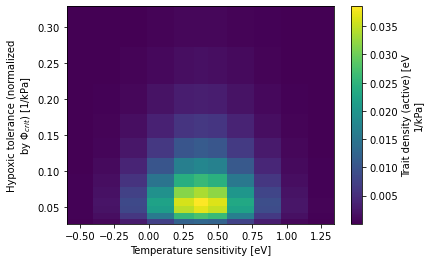

In [14]:
dso.trait_spc_active.plot();

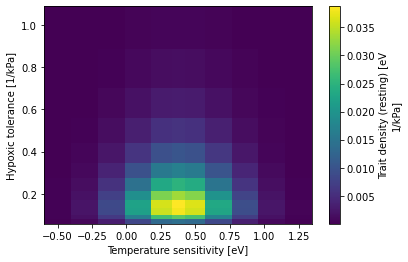

In [15]:
dso.trait_spc_resting.plot();

### Generate a higher resolution version of trait space

In [16]:
dso_hires = gen_trait_space(
    mi.trait_pdf(df, 'Ac', 30, [df.Ac.min(), df.Ac.max()]),
    mi.trait_pdf(df, 'Ao', 30, [df.Ao.min(), df.Ao.max()]),
    mi.trait_pdf(df, 'Eo', 30, [-1, 2.0]),
)
dso_hires

<xarray.Dataset>
Dimensions:            (Ao: 30, Ac: 30, Eo: 30)
Coordinates:
  * Ao                 (Ao) float64 0.0613 0.0684 0.0762 ... 1.15 1.282 1.429
  * Ac                 (Ac) float64 0.0258 0.0287 0.0319 ... 0.4973 0.5528
  * Eo                 (Eo) float64 -1.0 -0.8966 -0.7931 ... 1.793 1.897 2.0
Data variables:
    Ao_cdf             (Ao) float64 0.005202 0.01298 0.02624 ... 0.9925 0.9949
    Ac_cdf             (Ac) float64 0.002015 0.008067 0.02132 ... 0.9975 0.9984
    Eo_cdf             (Eo) float64 5.311e-07 3.176e-06 1.673e-05 ... 1.0 1.0
    Ao_pdf             (Ao) float64 0.811 1.385 2.005 ... 0.02088 0.01315
    Ac_pdf             (Ac) float64 1.239 3.018 5.267 ... 0.03646 0.02182 0.0128
    Eo_pdf             (Eo) float64 9.517e-06 5.296e-05 ... 8.239e-07 1.088e-07
    trait_spc_active   (Ac, Eo) float64 9.205e-09 5.123e-08 ... 1.087e-12
    trait_spc_resting  (Ao, Eo) float64 1.651e-08 9.187e-08 ... 3.06e-12

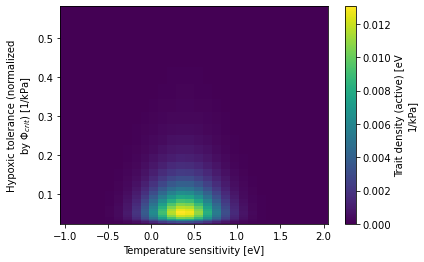

In [17]:
dso_hires.trait_spc_active.plot()

## Solve for maximum metabolic temperature 

Use root finding technique to solve for $AT_{max}$ (the maximum temerature at which metabolism can be sustained) over all traits.

First illustrate computation on a subset of traits.

In [18]:
mi.dEodT_bar

0.022

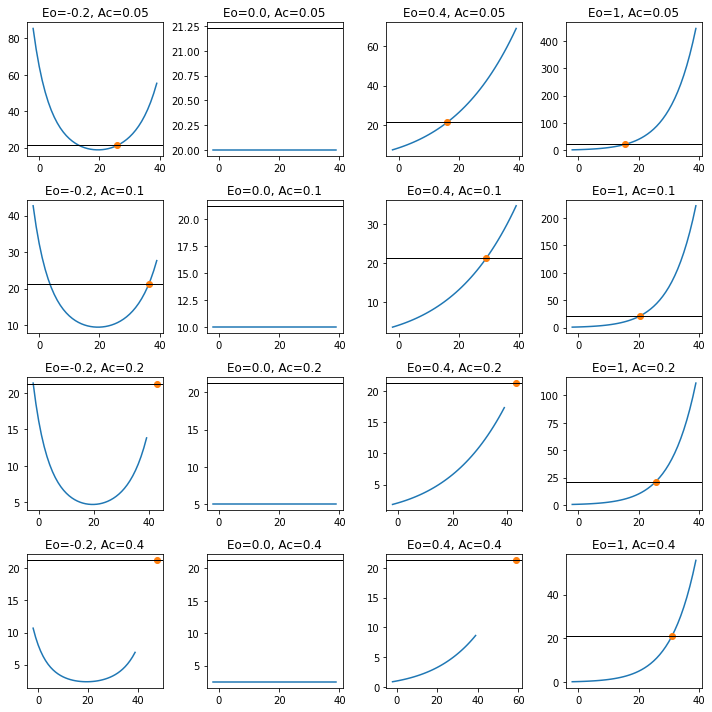

In [19]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

PO2_atm = constants.XiO2 * constants.kPa_per_atm

T = np.arange(-2.0, 40.0, 1.0)


for i, Ac in enumerate([0.05, 0.1, 0.2, 0.4]):
    for j, Eo in enumerate([-0.2, 0.0, 0.4, 1]):

        dEodT = mi.dEodT_bar if Eo < 0 else 0.0

        ax = axs[i, j]
        ATmax_ij = mi.compute_ATmax(PO2_atm, Ac, Eo, dEodT=dEodT)
        ax.plot(T, mi.pO2_at_Phi_one(T, Ac, Eo, dEodT=dEodT), '-')
        ax.plot(ATmax_ij, PO2_atm, 'o')
        ax.axhline(PO2_atm, linewidth=1, color='k')
        ax.set_title(f'Eo={Eo}, Ac={Ac}')

fig.tight_layout()

Now compute ATmax over entire trait-space domain.

In [20]:
PO2_atm = constants.XiO2 * constants.kPa_per_atm


def solve_ATmax_over_trait_space(trait_space):

    dEodT = mi.dEodT_bar

    metabolic_baseline = trait_space.attrs['metabolic_baseline']
    hypoxic_tol, temp_sens = trait_space.dims

    ATmax = xr.full_like(trait_space, fill_value=0.0)
    ATmax.name = f'ATmax_{metabolic_baseline}'
    ATmax.attrs['long_name'] = 'AT$_{max}$' + f' ({metabolic_baseline})'
    ATmax.attrs['units'] = '°C'
    ATmax.attrs['note'] = f'computed using dEodT = {dEodT}'

    for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
        for j, Eo in enumerate(trait_space[temp_sens].values):

            ATmax_ij = mi.compute_ATmax(PO2_atm, Ac=A_parm, Eo=Eo, dEodT=dEodT)
            ATmax[i, j] = ATmax_ij

    return ATmax


for v in ['trait_spc_active', 'trait_spc_resting']:
    ATmax = solve_ATmax_over_trait_space(dso[v])
    dso[ATmax.name] = ATmax

    ATmax = solve_ATmax_over_trait_space(dso_hires[v])
    dso_hires[ATmax.name] = ATmax

dso

<xarray.Dataset>
Dimensions:            (Ao: 12, Ac: 12, Eo: 11)
Coordinates:
  * Ao                 (Ao) float64 0.06811 0.08867 0.1147 ... 0.784 0.9872
  * Ac                 (Ac) float64 0.03 0.037 0.0456 ... 0.1974 0.2433 0.3
  * Eo                 (Eo) float64 -0.5 -0.3056 -0.1111 ... 0.8611 1.056 1.25
Data variables:
    Ao_cdf             (Ao) float64 0.01258 0.05662 0.1439 ... 0.9634 0.9818
    Ac_cdf             (Ac) float64 0.01258 0.05662 0.1439 ... 0.9634 0.9818
    Eo_cdf             (Eo) float64 0.0009272 0.007643 0.0411 ... 0.9915 0.9989
    Ao_pdf             (Ao) float64 1.361 2.824 3.714 ... 0.2847 0.1348 0.05895
    Ac_pdf             (Ac) float64 3.927 8.428 11.39 ... 0.996 0.4794 0.2129
    Eo_pdf             (Eo) float64 0.0111 0.07442 0.3113 ... 0.08196 0.01257
    trait_spc_active   (Ac, Eo) float64 0.0001004 0.0006727 ... 6.159e-06
    trait_spc_resting  (Ao, Eo) float64 0.0001098 0.0007361 ... 5.384e-06
    ATmax_active       (Ac, Eo) float64 nan nan nan nan ... 27.2 25.63 24.37
    ATmax_resting      (Ao, Eo) float64 42.49 35.22 29.01 ... 33.29 31.24 29.54

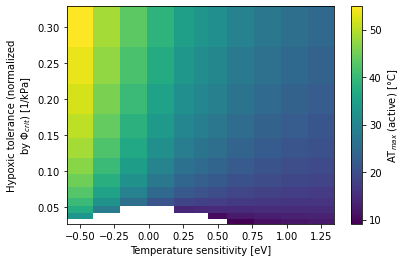

In [21]:
dso.ATmax_active.plot();

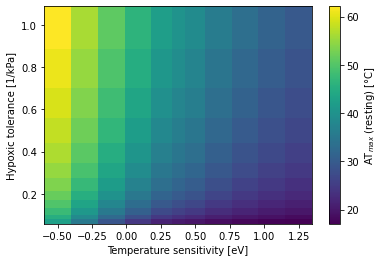

In [22]:
dso.ATmax_resting.plot();

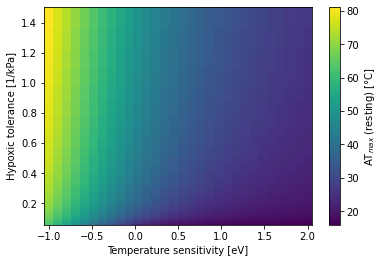

In [23]:
dso_hires.ATmax_resting.plot()

## Write out cached trait-space data

In [24]:
clobber = True

this_notebook = 'trait-space-joint-pdf.ipynb'

curator = util.curator_local_assets()

if clobber:
    cache_file = 'data/cache/trait-space.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    dso.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key='trait-space',
        urlpath=cache_file,
        description=f'Idealized trait space generated by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )

    cache_file = 'data/cache/trait-space-hires.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    dso_hires.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key='trait-space-hires',
        urlpath=cache_file,
        description=f'Idealized trait space generated by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )

cat = curator.open_catalog()
ds_cache = cat['trait-space'].to_dask()
xr.testing.assert_identical(dso, ds_cache)

cat = curator.open_catalog()
ds_cache = cat['trait-space-hires'].to_dask()
xr.testing.assert_identical(dso_hires, ds_cache)

overwriting "trait-space" key in "sources"
overwriting "trait-space-hires" key in "sources"


In [25]:
dso.info()

xarray.Dataset {
dimensions:
	Ao = 12 ;
	Ac = 12 ;
	Eo = 11 ;

variables:
	float64 Ao(Ao) ;
		Ao:long_name = Hypoxic tolerance ;
		Ao:units = 1/kPa ;
	float64 Ac(Ac) ;
		Ac:long_name = Hypoxic tolerance (normalized by $\Phi_{crit}$) ;
		Ac:units = 1/kPa ;
	float64 Eo(Eo) ;
		Eo:long_name = Temperature sensitivity ;
		Eo:units = eV ;
	float64 Ao_cdf(Ao) ;
	float64 Ac_cdf(Ac) ;
	float64 Eo_cdf(Eo) ;
	float64 Ao_pdf(Ao) ;
	float64 Ac_pdf(Ac) ;
	float64 Eo_pdf(Eo) ;
	float64 trait_spc_active(Ac, Eo) ;
		trait_spc_active:long_name = Trait density (active) ;
		trait_spc_active:units = eV 1/kPa ;
		trait_spc_active:metabolic_baseline = active ;
		trait_spc_active:N_traits = 132 ;
	float64 trait_spc_resting(Ao, Eo) ;
		trait_spc_resting:long_name = Trait density (resting) ;
		trait_spc_resting:units = eV 1/kPa ;
		trait_spc_resting:metabolic_baseline = resting ;
		trait_spc_resting:N_traits = 132 ;
	float64 ATmax_active(Ac, Eo) ;
		ATmax_active:long_name = AT$_{max}$ (active) ;
		ATmax_active:

In [26]:
dso_hires.info()

xarray.Dataset {
dimensions:
	Ao = 30 ;
	Ac = 30 ;
	Eo = 30 ;

variables:
	float64 Ao(Ao) ;
		Ao:long_name = Hypoxic tolerance ;
		Ao:units = 1/kPa ;
	float64 Ac(Ac) ;
		Ac:long_name = Hypoxic tolerance (normalized by $\Phi_{crit}$) ;
		Ac:units = 1/kPa ;
	float64 Eo(Eo) ;
		Eo:long_name = Temperature sensitivity ;
		Eo:units = eV ;
	float64 Ao_cdf(Ao) ;
	float64 Ac_cdf(Ac) ;
	float64 Eo_cdf(Eo) ;
	float64 Ao_pdf(Ao) ;
	float64 Ac_pdf(Ac) ;
	float64 Eo_pdf(Eo) ;
	float64 trait_spc_active(Ac, Eo) ;
		trait_spc_active:long_name = Trait density (active) ;
		trait_spc_active:units = eV 1/kPa ;
		trait_spc_active:metabolic_baseline = active ;
		trait_spc_active:N_traits = 900 ;
	float64 trait_spc_resting(Ao, Eo) ;
		trait_spc_resting:long_name = Trait density (resting) ;
		trait_spc_resting:units = eV 1/kPa ;
		trait_spc_resting:metabolic_baseline = resting ;
		trait_spc_resting:N_traits = 900 ;
	float64 ATmax_active(Ac, Eo) ;
		ATmax_active:long_name = AT$_{max}$ (active) ;
		ATmax_active: